# Kidney Stone Detection Model Evaluation

This notebook evaluates the performance of the trained VGG16 model for kidney stone detection from CT scan images.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
%pwd

'c:\\Users\\manob\\Documents\\Kidney_Disease_Detection\\Kidney_Disease_Detection\\Pretrained Models\\VGG16'

In [3]:
os.chdir("../")
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\manob\\Documents\\Kidney_Disease_Detection\\Kidney_Disease_Detection'

In [5]:
# Configuration
BASE_DIR = "artifacts/data_ingestion/Combined_Training_Data"
MODEL_PATH = "Pretrained Models/VGG16/vgg16_kidney_stone_model_trained.h5"  # Path to the trained model
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

# Create directory for evaluation results
RESULTS_DIR = "Pretrained Models/VGG16/evaluation_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [6]:
# Load the trained model
model = load_model(MODEL_PATH)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [7]:
# Create a test data generator (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# We'll use the validation split as our test set for evaluation
test_generator = test_datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important: don't shuffle for evaluation
)

# Print class mapping
print(f"Class indices: {test_generator.class_indices}")

Found 38821 images belonging to 2 classes.
Class indices: {'Non-Stone': 0, 'Stone': 1}


In [8]:
# Evaluate the model
evaluation = model.evaluate(test_generator)
metrics_names = model.metrics_names

# Print evaluation results
print("\nModel Evaluation Results:")
for name, value in zip(metrics_names, evaluation):
    print(f"{name}: {value:.4f}")

1214/1214 [==============================] - 3660s 3s/step - loss: 0.0882 - accuracy: 0.9606 - auc: 0.9954 - precision: 0.9609 - recall: 0.9548

Model Evaluation Results:
loss: 0.0882
accuracy: 0.9606
auc: 0.9954
precision: 0.9609
recall: 0.9548


In [9]:
# Get predictions
test_generator.reset()
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Make sure predictions and true labels have the same length
y_pred = y_pred[:len(y_true)]
y_pred_prob = y_pred_prob[:len(y_true)]

1214/1214 [==============================] - 3699s 3s/step


In [10]:
# Generate classification report
class_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)

# Save the report to a file
with open(f"{RESULTS_DIR}/classification_report.txt", "w") as f:
    f.write(report)


Classification Report:
              precision    recall  f1-score   support

   Non-Stone       0.96      0.97      0.96     20627
       Stone       0.96      0.95      0.96     18194

    accuracy                           0.96     38821
   macro avg       0.96      0.96      0.96     38821
weighted avg       0.96      0.96      0.96     38821



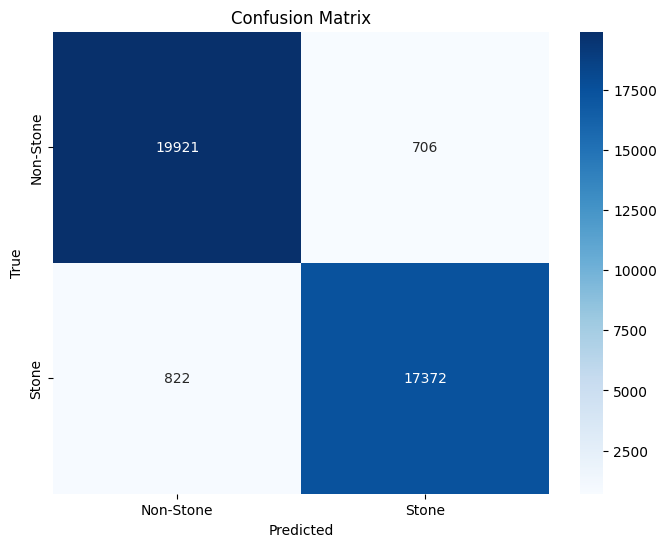

In [11]:
# Generate and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(f"{RESULTS_DIR}/confusion_matrix.png", bbox_inches='tight')
plt.show()

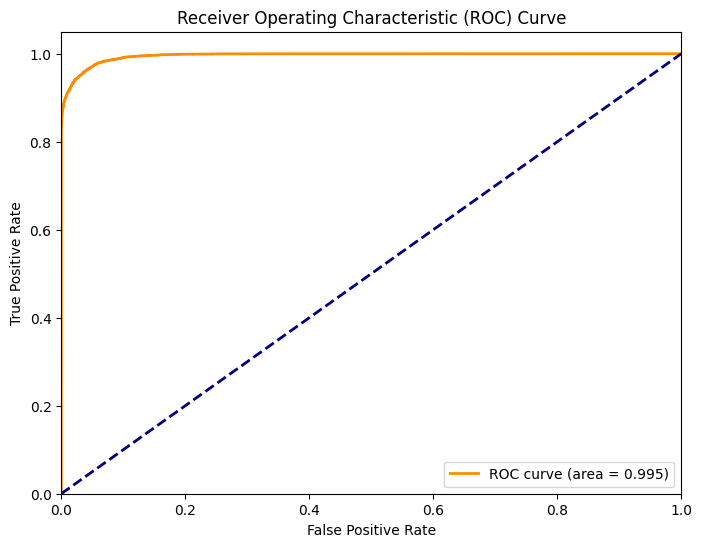

In [12]:
# Generate and plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig(f"{RESULTS_DIR}/roc_curve.png", bbox_inches='tight')
plt.show()

1/1 [==============================] - 3s 3s/step


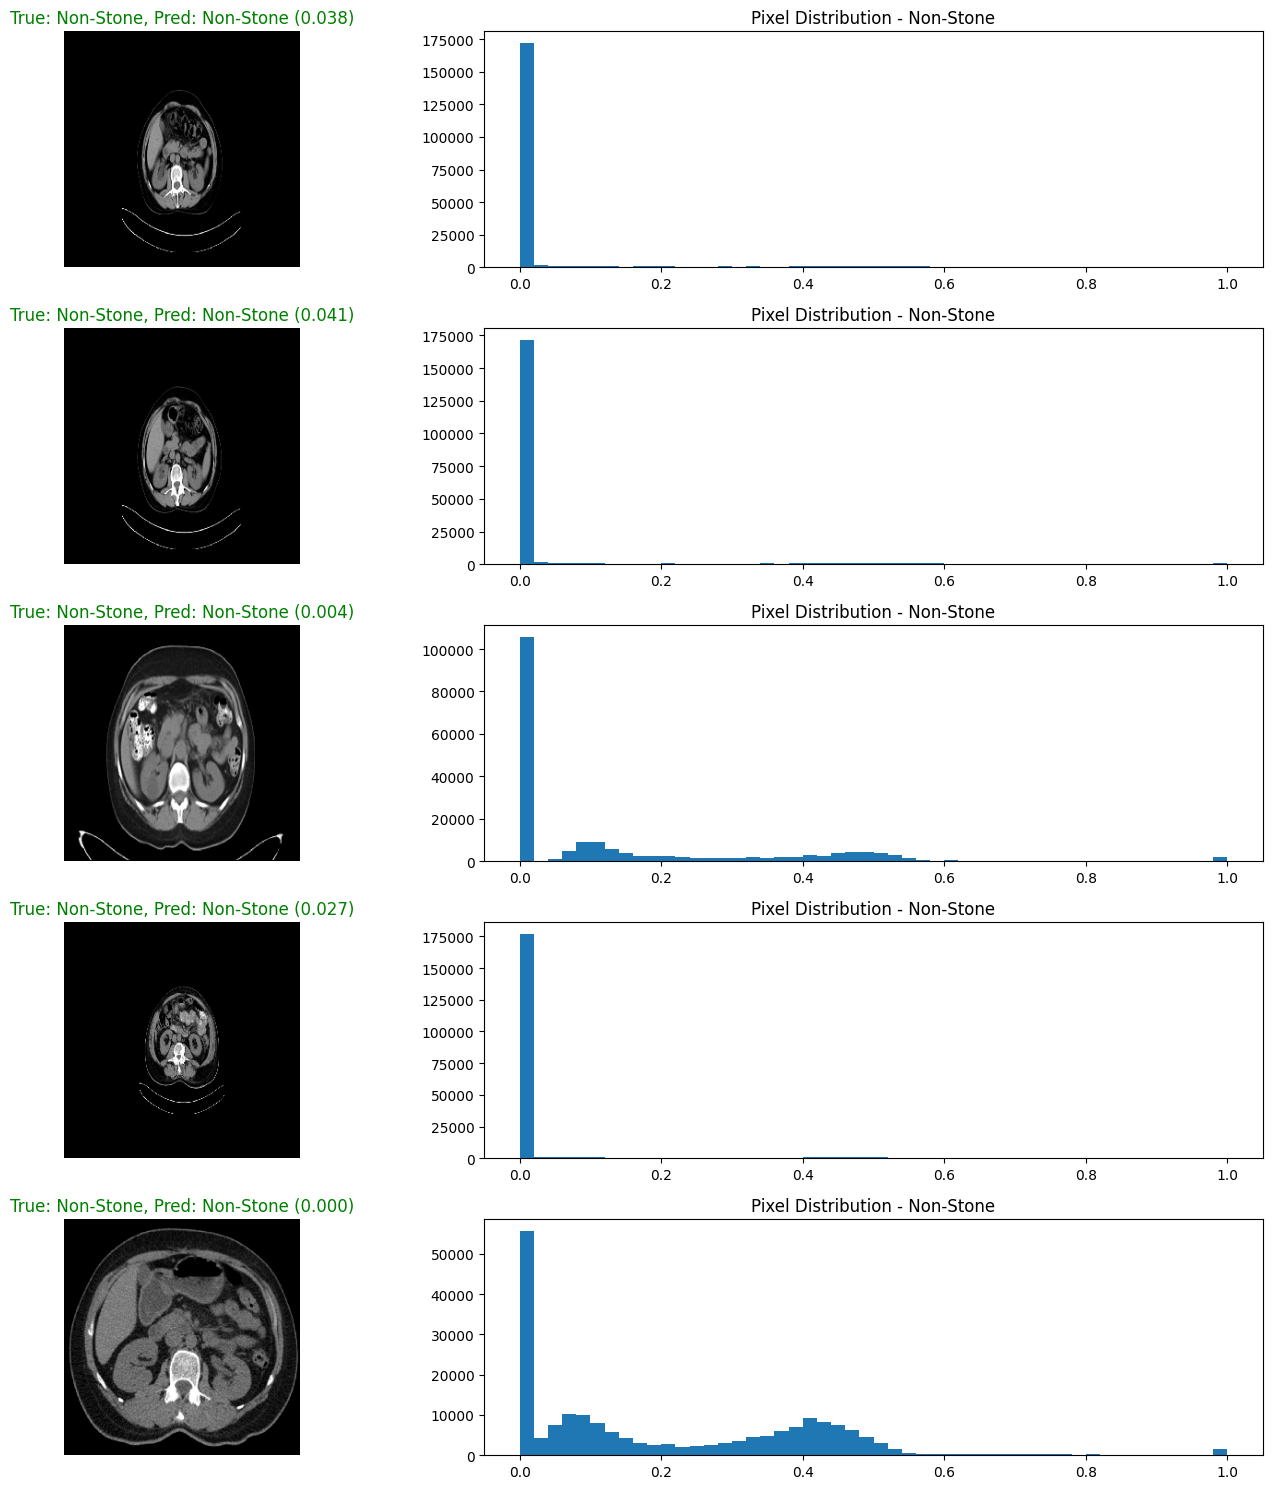

In [13]:
# Visualize some example predictions
def plot_sample_predictions(generator, model, num_samples=5):
    generator.reset()
    
    # Get a batch of images and their true labels
    batch_x, batch_y = next(generator)
    
    # Make predictions
    preds = model.predict(batch_x)
    
    # Plot the images with their predictions
    plt.figure(figsize=(15, 3*num_samples))
    for i in range(min(num_samples, len(batch_x))):
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(batch_x[i])
        true_label = "Stone" if batch_y[i] == 1 else "Non-Stone"
        pred_label = "Stone" if preds[i][0] > 0.5 else "Non-Stone"
        pred_prob = preds[i][0]
        title = f"True: {true_label}, Pred: {pred_label} ({pred_prob:.3f})"
        plt.title(title, color='green' if true_label == pred_label else 'red')
        plt.axis('off')
        
        # Add a histogram of pixel values to understand image characteristics
        plt.subplot(num_samples, 2, 2*i+2)
        plt.hist(batch_x[i].flatten(), bins=50)
        plt.title(f"Pixel Distribution - {true_label}")
    
    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/sample_predictions.png", bbox_inches='tight')
    plt.show()

# Plot some sample predictions
plot_sample_predictions(test_generator, model, num_samples=5)